In [24]:
from experiments import experiments
import os
import sys
sys.path.append('/home/maria/NeuroFarm/neuromatch2024_experiments')

from neuromatch2024_experiments.q_networks import RNNQNetwork, LSTMQNetwork, GRUQNetwork
from neuromatch2024_experiments.agents import DQNAgent
from environments import DelaySampleToMatchEnv
from neuromatch2024_experiments.eval_scripts import prepare_data
import numpy as np
import matplotlib.pyplot as plt


def move_tuple_to_device(hidden_tuple, device):
    return (hidden_tuple[0].to(device), hidden_tuple[1].to(device))


experiment = experiments[("long-seq", "cifar10-seq", "LSTM", "Rew-100")]
experiment = experiments[("long-seq", "cifar10-seq", "LSTM", "Rew-10")]
print(experiment['reward'])

env = DelaySampleToMatchEnv(reward=experiment['reward'], n_stimuli=experiment['action_size'] - 1)
agent = DQNAgent(experiment)

agent.load_model('eval')

agent.epsilon = 0.00

print(agent.q_network)

n_episodes = 10
win_pct_list = []
scores = []
hids = []

train_data, class_dct = prepare_data()

percent_correct=[]
acts=[]
for i in range(n_episodes):
    done = False
    state = env.reset()  # Reset the environment
    indices = class_dct[int(state)]
    random_index = np.random.choice(indices)
    state = train_data[random_index].flatten()
    score = 0
    hidden = agent.q_network.init_hidden()
    if isinstance(hidden, tuple):
        hidden = move_tuple_to_device(hidden, agent.device)
    else:
        hidden = hidden.to(agent.device)
    cnt=0
    while not done:
        action, next_hidden = agent.select_action(state, hidden)
        next_state, reward, done, info = env.step(action)  # Take the actio
        indices = class_dct[int(next_state)]
        random_index = np.random.choice(indices)
        next_state = train_data[random_index].flatten()
        hidden = next_hidden
        state = next_state  # Move to the next state
        score += reward
        if isinstance(hidden, tuple):
            hids.append(hidden[0].detach().cpu().numpy())
        else:
            hids.append(hidden.detach().cpu().numpy())
        #if cnt%22==0:
            #print(reward)
        #cnt+=1
        if done:
            #print(reward)
            acts.append(action)
            if reward==experiment['reward']:
                percent_correct.append(1)
            else: 
                percent_correct.append(0)


hids = np.array(hids).squeeze(1).squeeze(1)
print(hids.shape)
print(hids)



10
LSTMQNetwork(
  (rnn): LSTM(10, 128)
  (fc): Linear(in_features=128, out_features=11, bias=True)
)
(220, 128)
[[ 0.7381967  -0.00128101  0.00600733 ...  0.0056869  -0.0139403
   0.9372453 ]
 [ 0.84017324 -0.5016441  -0.37820795 ... -0.5915203   0.63325864
   0.8735347 ]
 [ 0.62990177 -0.71542764 -0.29508466 ... -0.4944083   0.669066
   0.8028367 ]
 ...
 [ 0.5741439  -0.65893924 -0.12786572 ... -0.32660404  0.67533696
   0.75494057]
 [ 0.5796097  -0.68015677 -0.1309259  ... -0.4457207   0.6619816
   0.7630948 ]
 [ 0.7965902  -0.5478353  -0.04562951 ... -0.67172015  0.72192353
   0.79823655]]


(128, 220)
2024-07-25 11:03:03,047 [INFO] normalizing data across axis=1
2024-07-25 11:03:03,049 [INFO] projecting out mean along axis=0
2024-07-25 11:03:03,052 [INFO] data normalized, 0.00sec
2024-07-25 11:03:03,055 [INFO] sorting activity: 128 valid samples by 111 timepoints
2024-07-25 11:03:03,106 [INFO] n_PCs = 10 computed, 0.06sec
2024-07-25 11:03:03,147 [INFO] 5 clusters computed, time 0.10sec
2024-07-25 11:03:03,153 [INFO] clusters sorted, time 0.11sec
2024-07-25 11:03:03,214 [INFO] clusters upsampled, time 0.17sec
2024-07-25 11:03:03,217 [INFO] rastermap complete, time 0.17sec


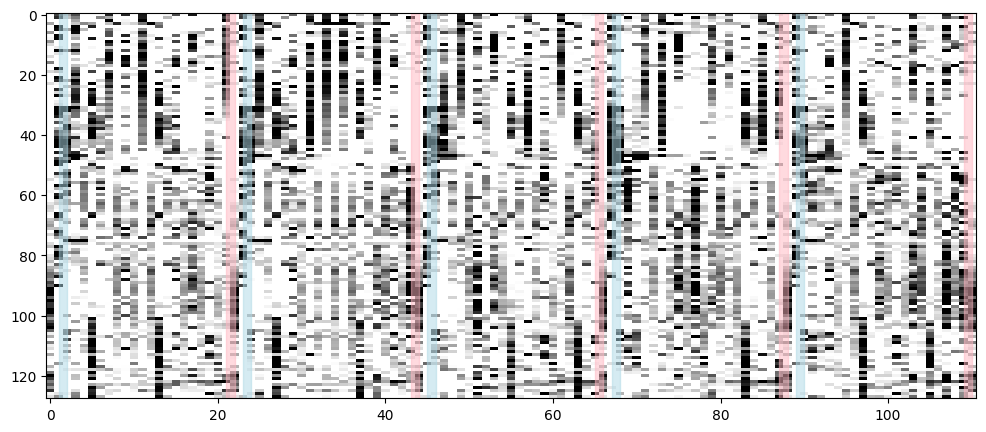

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from rastermap import Rastermap, utils
from scipy.stats import zscore

# Assuming 'hids' is predefined and loaded
spks = hids.T
print(spks.shape)
spks = zscore(spks, axis=1)
spks = spks[:, :111]

# Fit rastermap
model = Rastermap(n_PCs=10, n_clusters=5, 
                  locality=0.75, time_lag_window=5).fit(spks, compute_X_embedding=True)
y = model.embedding # neurons x 1
isort = model.isort

# Visualize binning over neurons
X_embedding = model.X_embedding

# Define vertical span ranges and colors
vertical_spans = []
for i in range(1, 110, 22):
    vertical_spans.append((i, i+1, 'lightblue'))
    vertical_spans.append((i+20, i+21, 'lightpink'))

# Define horizontal span ranges and colors
horizontal_spans = [(0, 23, 'lightblue'),
                    (24, 53, 'lightpink'),
                    (54, 66, 'lightblue'),
                    (67, 108, 'lightpink'),
                    (109, 128, 'lightblue')]


# Plot
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(111)
ax.imshow(X_embedding, vmin=0, vmax=1.5, cmap="gray_r", aspect="auto")

# Add vertical spans
for start, end, color in vertical_spans:
    ax.axvspan(start, end, color=color, alpha=0.5)

#Add horizontal spans
# for start, end, color in horizontal_spans:
#     ax.axhspan(start, end, color=color, alpha=0.5)

plt.show()

(128, 220)
2024-07-25 10:46:46,740 [INFO] normalizing data across axis=1
2024-07-25 10:46:46,742 [INFO] projecting out mean along axis=0
2024-07-25 10:46:46,745 [INFO] data normalized, 0.00sec
2024-07-25 10:46:46,746 [INFO] sorting activity: 128 valid samples by 220 timepoints
2024-07-25 10:46:46,756 [INFO] n_PCs = 10 computed, 0.02sec
2024-07-25 10:46:46,792 [INFO] 5 clusters computed, time 0.05sec
2024-07-25 10:46:46,837 [INFO] clusters sorted, time 0.10sec
2024-07-25 10:46:46,867 [INFO] clusters upsampled, time 0.13sec
2024-07-25 10:46:46,871 [INFO] rastermap complete, time 0.13sec


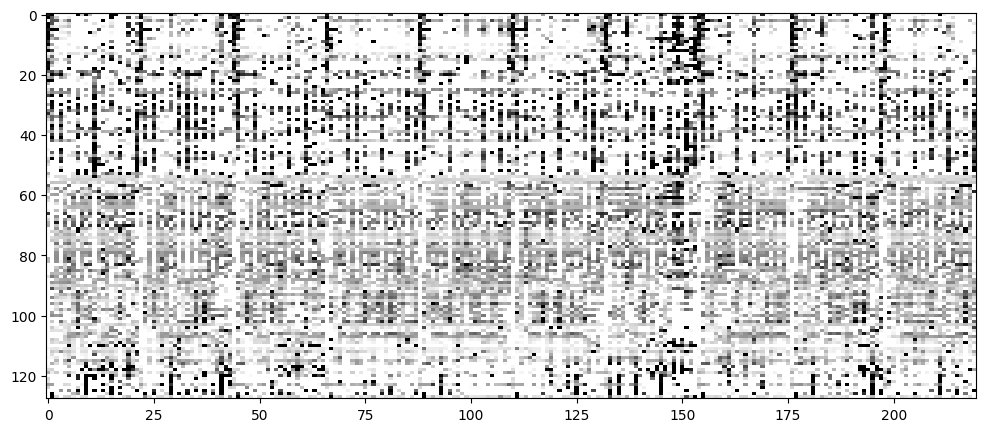

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from rastermap import Rastermap, utils
from scipy.stats import zscore

spks=hids.T
print(spks.shape)
spks = zscore(spks, axis=1)
#spks=spks[:,:100]
# fit rastermap
model = Rastermap(n_PCs=10, n_clusters=5, 
                  locality=0.75, time_lag_window=5).fit(spks, compute_X_embedding=True)
y = model.embedding # neurons x 1
isort = model.isort

# visualize binning over neurons
X_embedding = model.X_embedding

# plot
fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(111)
ax.imshow(X_embedding, vmin=0, vmax=1.5, cmap="gray_r", aspect="auto")

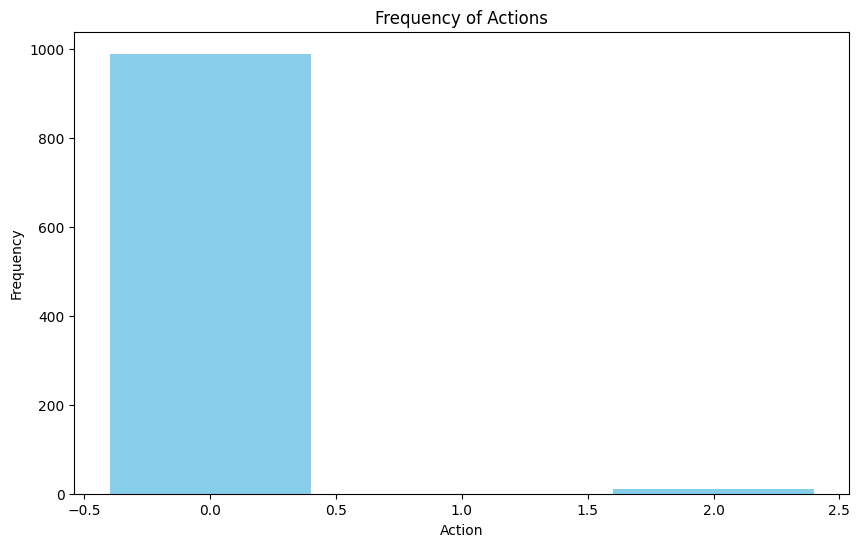

In [15]:

import matplotlib.pyplot as plt
from collections import Counter

def plot_action_frequencies(actions):
    # Calculate the frequency of each action
    action_counter = Counter(actions)
    
    # Extract the actions and their frequencies
    actions_list = list(action_counter.keys())
    frequencies = list(action_counter.values())
    
    # Plotting the bar chart
    plt.figure(figsize=(10, 6))
    plt.bar(actions_list, frequencies, color='skyblue')
    
    # Adding title and labels
    plt.title('Frequency of Actions')
    plt.xlabel('Action')
    plt.ylabel('Frequency')
    
    # Show the plot
    plt.show()

# Example usage
#actions = [1, 2, 3, 1, 2, 1, 4, 2, 3, 4, 2]
plot_action_frequencies(acts)

In [3]:
print(sum(percent_correct))

8199


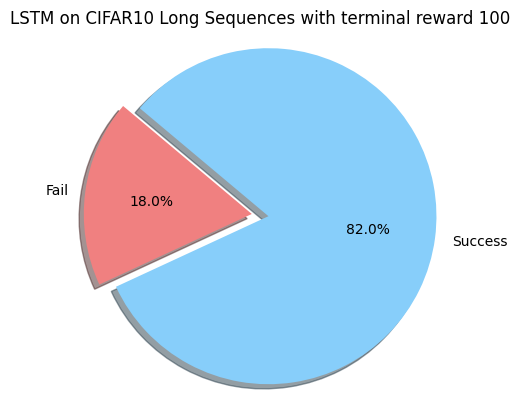

In [7]:
import matplotlib.pyplot as plt

# Example vector
vector = percent_correct

# Count the occurrences of 0s and 1s
fail_count = vector.count(0)
success_count = vector.count(1)

# Data to plot
labels = 'Fail', 'Success'
sizes = [fail_count, success_count]
colors = ['lightcoral', 'lightskyblue']
explode = (0.1, 0)  # explode 1st slice (Fail)

# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=140)

plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('LSTM on CIFAR10 Long Sequences with terminal reward 100')
plt.show()

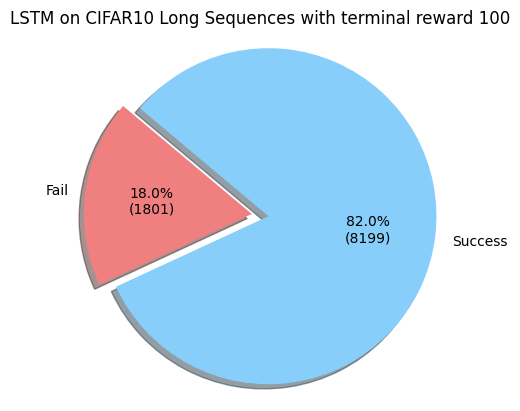

In [9]:
# Count the occurrences of 0s and 1s
fail_count = vector.count(0)
success_count = vector.count(1)

# Data to plot
labels = 'Fail', 'Success'
sizes = [fail_count, success_count]
colors = ['lightcoral', 'lightskyblue']
explode = (0.1, 0)  # explode 1st slice (Fail)

def autopct_format(values):
    def my_format(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return f'{pct:.1f}%\n({val})'
    return my_format

# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct=autopct_format(sizes), shadow=True, startangle=140)

plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('LSTM on CIFAR10 Long Sequences with terminal reward 100')
plt.show()

In [3]:
from experiments import experiments
import os
import sys
sys.path.append('/home/maria/NeuroFarm/neuromatch2024_experiments')

from neuromatch2024_experiments.q_networks import RNNQNetwork, LSTMQNetwork, GRUQNetwork
from neuromatch2024_experiments.agents import DQNAgent
from environments import DelaySampleToMatchEnv
from neuromatch2024_experiments.eval_scripts import prepare_data
import numpy as np
import matplotlib.pyplot as plt


def move_tuple_to_device(hidden_tuple, device):
    return (hidden_tuple[0].to(device), hidden_tuple[1].to(device))


experiment = experiments[("long-seq", "cifar10-seq", "LSTM", "Rew-10")]
#experiment = experiments[("short-seq", "cifar10-seq", "LSTM", "Rew-10")]
print(experiment['reward'])

env = DelaySampleToMatchEnv(reward=experiment['reward'], n_stimuli=experiment['action_size'] - 1)
agent = DQNAgent(experiment)

agent.load_model('eval')

agent.epsilon = 0.00

print(agent.q_network)

n_episodes = 10000
win_pct_list = []
scores = []
hids = []

train_data, class_dct = prepare_data()

percent_correct=[]
for i in range(n_episodes):
    done = False
    state = env.reset()  # Reset the environment
    indices = class_dct[int(state)]
    random_index = np.random.choice(indices)
    state = train_data[random_index].flatten()
    score = 0
    hidden = agent.q_network.init_hidden()
    if isinstance(hidden, tuple):
        hidden = move_tuple_to_device(hidden, agent.device)
    else:
        hidden = hidden.to(agent.device)
    cnt=0
    while not done:
        action, next_hidden = agent.select_action(state, hidden)
        next_state, reward, done, info = env.step(action)  # Take the action
        indices = class_dct[int(next_state)]
        random_index = np.random.choice(indices)
        next_state = train_data[random_index].flatten()
        hidden = next_hidden
        # hids.append(hidden)
        state = next_state  # Move to the next state
        score += reward
        #if isinstance(hidden, tuple):
            #hids.append(hidden[0].detach().cpu().numpy())
        #else:
            #hids.append(hidden.detach().cpu().numpy())
        #if cnt%22==0:
            #print(reward)
        #cnt+=1
        if done:
            print(reward)
            if reward==experiment['reward']:
                percent_correct.append(1)
            else: 
                percent_correct.append(0)






10
LSTMQNetwork(
  (rnn): LSTM(10, 128)
  (fc): Linear(in_features=128, out_features=11, bias=True)
)
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
10
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
10
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
10
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
10
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
10
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
10
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-

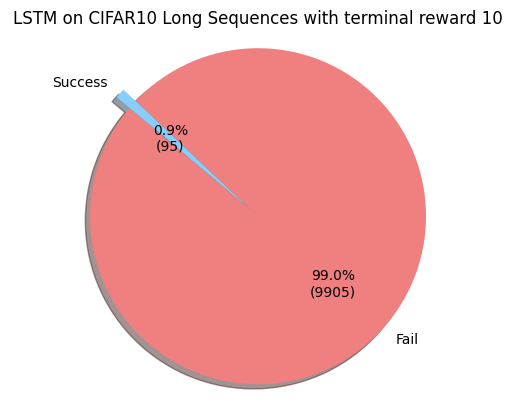

In [5]:
vector=percent_correct
# Count the occurrences of 0s and 1s
fail_count = vector.count(0)
success_count = vector.count(1)

# Data to plot
labels = 'Fail', 'Success'
sizes = [fail_count, success_count]
colors = ['lightcoral', 'lightskyblue']
explode = (0.1, 0)  # explode 1st slice (Fail)

def autopct_format(values):
    def my_format(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return f'{pct:.1f}%\n({val})'
    return my_format

# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct=autopct_format(sizes), shadow=True, startangle=140)

plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('LSTM on CIFAR10 Long Sequences with terminal reward 10')
plt.show()